# Model definition

In [2]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet50KeypointModel(nn.Module):
    def __init__(self):
        super(ResNet50KeypointModel, self).__init__()
        # Load the pre-trained ResNet50 model
        self.base_model = models.resnet50(pretrained=True)
        # Modify the final layer to output 24 values (12 key points with x and y coordinates)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 24) 

    def forward(self, x):
        return self.base_model(x)

model = ResNet50KeypointModel()


C:\Users\avs20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\avs20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Model training and data loading

In [2]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Dataset Definition
class KeyPointDataset(Dataset):
    def __init__(self, image_paths, key_points, transform=None):
        self.image_paths = image_paths
        self.key_points = key_points
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")  # Ensure images are in RGB format
        key_point = self.key_points[idx]

        if self.transform:
            image = self.transform(image)

        return image, key_point

# Function to load dataset from a specified folder
def load_dataset(folder_path):
    # Load key points from the CSV file
    csv_file = os.path.join(folder_path, 'augmented_labels.csv')  # Change to your CSV file name
    keypoint_data = pd.read_csv(csv_file)

    # Create lists for images and key points
    image_paths = []
    key_points = []

    # Iterate through the CSV to get paths and key points
    for index, row in keypoint_data.iterrows():
        image_name = row['image_name']  # Replace with the actual column name in your CSV
        keypoint = row[1:].values.astype(float)  # Assuming the first column is the image name
        image_path = os.path.join(folder_path, f"{image_name}")  # Assuming images are in PNG format

        image_paths.append(image_path)
        key_points.append(torch.tensor(keypoint, dtype=torch.float32))  # Ensure keypoints are tensors of floats

    return image_paths, key_points

# Base path for your project
base_path = os.path.expanduser('~/Documents/GitHub/ViT_facemap/ViT-pytorch/projects/Facemap/data')

# Paths to your train and test folders
train_folder = os.path.join(base_path, 'train', 'augmented_data')
test_folder = os.path.join(base_path, 'test', 'augmented_data')

# Load datasets
train_image_paths, train_key_points = load_dataset(train_folder)
test_image_paths, test_key_points = load_dataset(test_folder)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create DataLoaders
train_dataset = KeyPointDataset(train_image_paths, train_key_points, transform)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = KeyPointDataset(test_image_paths, test_key_points, transform)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)


In [4]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model, move it to the GPU, and set it to training mode
model = ResNet50KeypointModel().to(device)
model.train()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10  # Adjust as necessary
for epoch in range(num_epochs):
    for img_batch, coord_batch in train_dataloader:
        # Move data to the GPU
        img_batch = img_batch.to(device)
        coord_batch = coord_batch.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(img_batch)  # Forward pass
        loss = criterion(outputs, coord_batch)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    # Save the trained model
    model_path = 'R50_model_shap2.pth'
    torch.save(model.state_dict(), model_path)


Epoch [1/10], Loss: 7052.9453
Epoch [2/10], Loss: 4949.8389
Epoch [3/10], Loss: 3177.5862
Epoch [4/10], Loss: 1943.2329
Epoch [5/10], Loss: 1097.6635
Epoch [6/10], Loss: 574.9530
Epoch [7/10], Loss: 288.4559
Epoch [8/10], Loss: 127.8032
Epoch [9/10], Loss: 53.5760
Epoch [10/10], Loss: 24.4134


# SHAP value visualization

In [3]:
# Load model data

model = ResNet50KeypointModel()
model.load_state_dict(torch.load('R50_model_shap2.pth'))


<All keys matched successfully>

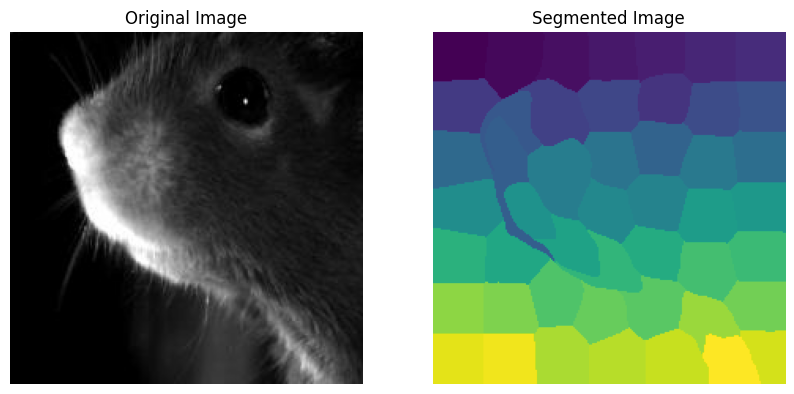

In [4]:
# Use SHAP explainer with my data

import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np
import shap

# Load an image
file = "data/cam1_G7c1_1_img0076_rescale_augmented.jpg"
img = image.load_img(file, target_size=(224, 224))
img_array = image.img_to_array(img)  # Convert to NumPy array directly here
img_orig = image.img_to_array(img)

# Segment the image so we don't have to explain every pixel
segments_slic = slic(img_array.astype('uint8'), n_segments=50, compactness=30, sigma=3)

# Create a color representation of the segments
#segmented_image = label2rgb(segments_slic, img_array.astype('uint8'), kind='avg')
segmented_image = segments_slic

# Display the original image and the segmented image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_array.astype('uint8'))  # Normalize for display
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.axis('off')

plt.show()


In [14]:
# Define a function to mask the image
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0, 1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i, :, :, :] = image
        for j in range(zs.shape[1]):
            if zs[i, j] == 0:
                out[i][segmentation == j, :] = background
    return out


# Define a function for SHAP to call the model
def f(z):
    masked_image = mask_image(z, segments_slic, img_array)  # Create the masked image
    #print(masked_image)
    #print(masked_image.shape)
    masked_image = preprocess_input(masked_image)  # Preprocess the masked image
    #print(masked_image)
    #print(masked_image.shape)
    masked_image_tensor = torch.from_numpy(masked_image.copy()).permute(0, 3, 1, 2).float()  # Make a copy and rearrange dimensions
    #print(masked_image)
    #print(masked_image.shape)
    with torch.no_grad():  # Disable gradient tracking
        return model(masked_image_tensor).numpy()  # Forward pass and convert to numpy

# Use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1, 50)))  # Initialize SHAP explainer with dummy data. I believe this dummy data used in the KERNEL SHAP instance in Github, is what in other SHAP explainers is the 'background', which can be your training images. But this is what they used in the github example, so I guess it should be valid enough.
shap_values = explainer.shap_values(np.ones((1, 50)), nsamples=200)  # Run SHAP with sample data

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
import torch
from torchvision import transforms

img_orig = image.img_to_array(img)

# Convert the image to a tensor and preprocess
img_tensor = torch.from_numpy(img_orig).permute(2, 0, 1).unsqueeze(0).float()  # Convert to tensor and reorder dimensions

# Define the preprocessing (normalization for ResNet50)
preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply preprocessing to the tensor (this assumes the image is already in float32 format)
img_tensor = preprocess(img_tensor[0]).unsqueeze(0)

# Move to the correct device if needed (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_tensor = img_tensor.to(device)

# Get the top predictions from the model
model = model.to(device)  # Make sure the model is on the same device
with torch.no_grad():
    preds = model(img_tensor)



In [16]:
print(preds)

tensor([[144.8701,  23.0885, 131.7148,  38.0607, 142.6199,  58.4381, 152.3761,
          52.4835,  43.9836,  47.9637,  31.2443,  63.8671,  39.2565,  87.2763,
          89.4495,  83.0075,  91.7044,  65.6879,  89.1379, 100.7531,  80.6231,
         135.0529,  92.5993, 141.8687]], device='cuda:0')


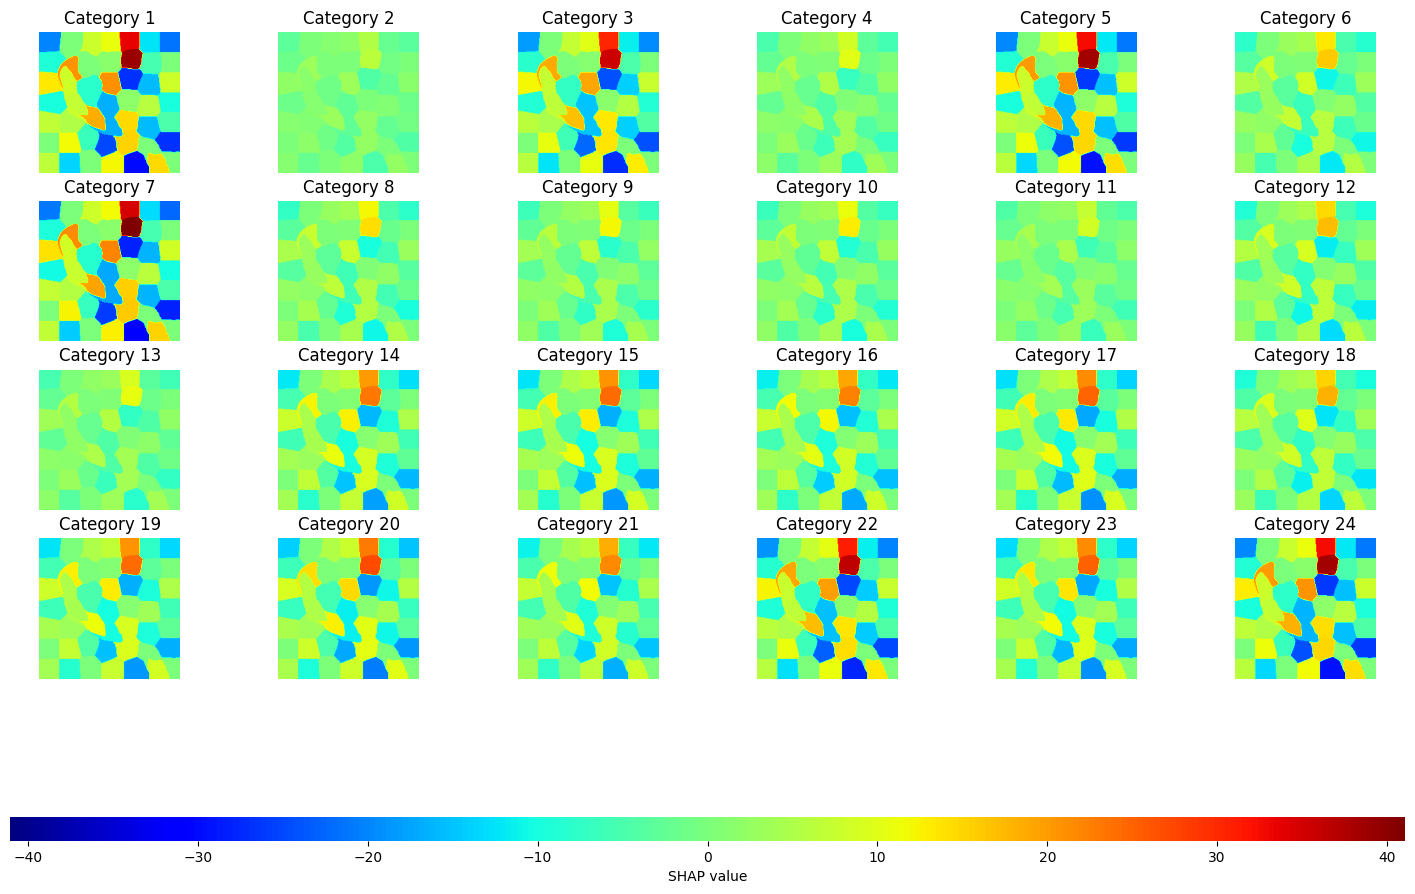

In [17]:
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import LinearSegmentedColormap

# Convert the image to a tensor and preprocess
img_tensor = torch.from_numpy(img_orig).permute(2, 0, 1).unsqueeze(0).float()  # Convert to tensor and reorder dimensions

# Define the preprocessing (normalization for ResNet50)
preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply preprocessing to the tensor (this assumes the image is already in float32 format)
img_tensor = preprocess(img_tensor[0]).unsqueeze(0)

# Move to the correct device if needed (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_tensor = img_tensor.to(device)

# Get the predictions from the model
model = model.to(device)  # Make sure the model is on the same device
with torch.no_grad():
    preds = model(img_tensor)

# Instead of top predictions, we will visualize all 24 categories
num_categories = 24  # Assuming 24 output categories

# make a color map
colors = []
for l in np.linspace(1, 0, 100):
    colors.append((245/255, 39/255, 87/255, l))
for l in np.linspace(0, 1, 100):
    colors.append((24/255, 196/255, 93/255, l))
cm = LinearSegmentedColormap.from_list("shap", colors)

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# Plot SHAP explanations for all output categories
fig, axes = pl.subplots(nrows=4, ncols=6, figsize=(18, 12))  # 4x6 grid for 24 categories

# Find max SHAP value for color scaling
max_val = np.max([np.max(np.abs(shap_values[i][:, :-1])) for i in range(len(shap_values))])

# Variable for storing the last valid imshow result
im = None

for i in range(num_categories):
    row = i // 6
    col = i % 6
    ax = axes[row, col]  # Get the corresponding subplot
    
    # Ensure the index is within bounds for shap_values
    if i < shap_values.shape[2]:  # Check if index is valid for SHAP values
        m = fill_segmentation(shap_values[0][:, i], segments_slic)  # Use shap_values[0] for a single prediction
        
        # Display the SHAP values overlayed on the image
        ax.imshow(img.convert('LA'), alpha=0.15)
        im = ax.imshow(m, cmap='jet', vmin=-max_val, vmax=max_val)  # Specify your colormap here
        ax.axis('off')
        ax.set_title(f'Category {i+1}')  # You can customize titles based on category names
    else:
        print(f"Index {i} is out of bounds for shap_values with shape {shap_values.shape}")

# Create a color bar only if `im` has been defined
if im is not None:
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)

pl.show()


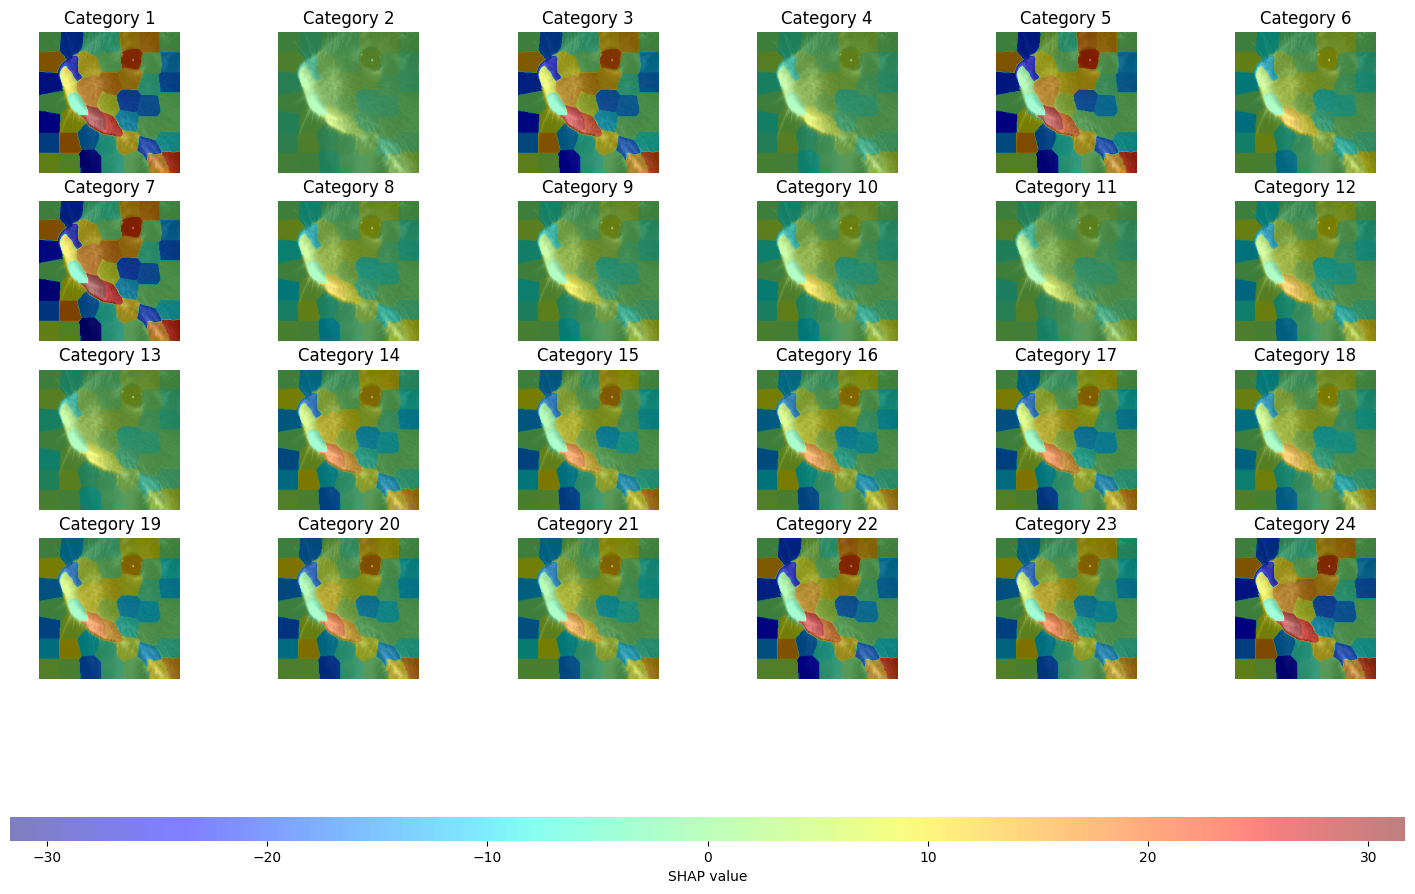

In [11]:
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import LinearSegmentedColormap

# Convert the image to a tensor and preprocess
img_tensor = torch.from_numpy(img_orig).permute(2, 0, 1).unsqueeze(0).float()  # Convert to tensor and reorder dimensions

# Define the preprocessing (normalization for ResNet50)
preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply preprocessing to the tensor (this assumes the image is already in float32 format)
img_tensor = preprocess(img_tensor[0]).unsqueeze(0)

# Move to the correct device if needed (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_tensor = img_tensor.to(device)

# Get the predictions from the model
model = model.to(device)  # Make sure the model is on the same device
with torch.no_grad():
    preds = model(img_tensor)

# Instead of top predictions, we will visualize all 24 categories
num_categories = 24  # Assuming 24 output categories

# make a color map
colors = []
for l in np.linspace(1, 0, 100):
    colors.append((245/255, 39/255, 87/255, l))
for l in np.linspace(0, 1, 100):
    colors.append((24/255, 196/255, 93/255, l))
cm = LinearSegmentedColormap.from_list("shap", colors)

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# Plot SHAP explanations for all output categories
fig, axes = pl.subplots(nrows=4, ncols=6, figsize=(18, 12))  # 4x6 grid for 24 categories

# Find max SHAP value for color scaling
max_val = np.max([np.max(np.abs(shap_values[i][:, :-1])) for i in range(len(shap_values))])

# Variable for storing the last valid imshow result
im = None

for i in range(num_categories):
    row = i // 6
    col = i % 6
    ax = axes[row, col]  # Get the corresponding subplot
    
    # Ensure the index is within bounds for shap_values
    if i < shap_values.shape[2]:  # Check if index is valid for SHAP values
        m = fill_segmentation(shap_values[0][:, i], segments_slic)  # Use shap_values[0] for a single prediction
        
        # Display the SHAP values overlayed on the original RGB image
        ax.imshow(img, alpha=1.0)  # Show original image
        im = ax.imshow(m, cmap='jet', vmin=-max_val, vmax=max_val, alpha=0.5)  # Overlay SHAP values with transparency
        ax.axis('off')
        ax.set_title(f'Category {i+1}')  # You can customize titles based on category names
    else:
        print(f"Index {i} is out of bounds for shap_values with shape {shap_values.shape}")

# Create a color bar only if `im` has been defined
if im is not None:
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)

pl.show()
